# Проект по теме "Временные ряды"

## Описание проекта

Компания «Чётенькое такси» собрала исторические данные о заказах такси в аэропортах. Чтобы привлекать больше водителей в период пиковой нагрузки, необходимо:
- Спрогнозировать количество заказов такси на следующий час. 
- Построить модель для такого предсказания.
- Значение метрики *RMSE* на тестовой выборке должно быть не больше 48.

### Инструкция по выполнению проекта

1. Загрузите данные и выполните их ресемплирование по одному часу.
2. Проанализируйте данные.
3. Обучите разные модели с различными гиперпараметрами. Сделайте тестовую выборку размером 10% от исходных данных.
4. Проверьте данные на тестовой выборке и сделайте выводы.

### Описание данных

Данные лежат в файле `taxi.csv`. Количество заказов находится в столбце '*num_orders*' (от англ. *number of orders*, «число заказов»).

**План выполнения работы:**  
- [1. Подготовка Данных](#секция1)  
- [2. Анализ данных](#секция2)  
- [3. Обучение моделей](#секция3)
- [4. Тестирование моделей](#секция4)  
- [5. Выводы](#секция5)  

<a id='секция1'></a>
# 1. Подготовка

Подключаем библиотеки:
- `pandas` - для работы с таблицами  
- `seaborn` - для визуализации данных
- `display` - для вывода табличных данных
- `sklearn` - инструменты машинного обучения (модели регрессии, метрики для исследования качества моделей, разделение данных, предобработка данных)

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.linear_model import LinearRegression, ElasticNet, Ridge, Lasso
from sklearn.metrics import mean_squared_error
import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

Загрузим данные из файлов, выведем первые 10 строк таблиц для первого взгляда на данные.  
Также с помощью метода info() изучим структуры таблиц: типы данных, количество строк, столбцов, пропущенных данных.

In [2]:
taxi = pd.read_csv('/datasets/taxi.csv', index_col='datetime', parse_dates=[0])

In [3]:
taxi.head()

,num_orders
datetime,
2018-03-01 00:00:00,9
2018-03-01 00:10:00,14
2018-03-01 00:20:00,28
2018-03-01 00:30:00,20
2018-03-01 00:40:00,32


In [4]:
taxi.shape

(26496, 1)

Выполним ресемплирование данных по одному часу. Поскольку предсказываем количество заказов такси на следующий час, аггрегируем суммы значений.

In [5]:
taxi = taxi.sort_index()
taxi = taxi.resample('1H').sum()

In [6]:
f"Временной промежуток данных: {taxi.index.min()} - {taxi.index.max()}"

'Временной промежуток данных: 2018-03-01 00:00:00 - 2018-08-31 23:00:00'

<a id='секция2'></a>
# 2. Анализ

Разложим данные на три составляющие: тренд, сезонность и остаток. Построим графики последнего месяца временного ряда и проанализируем данные.

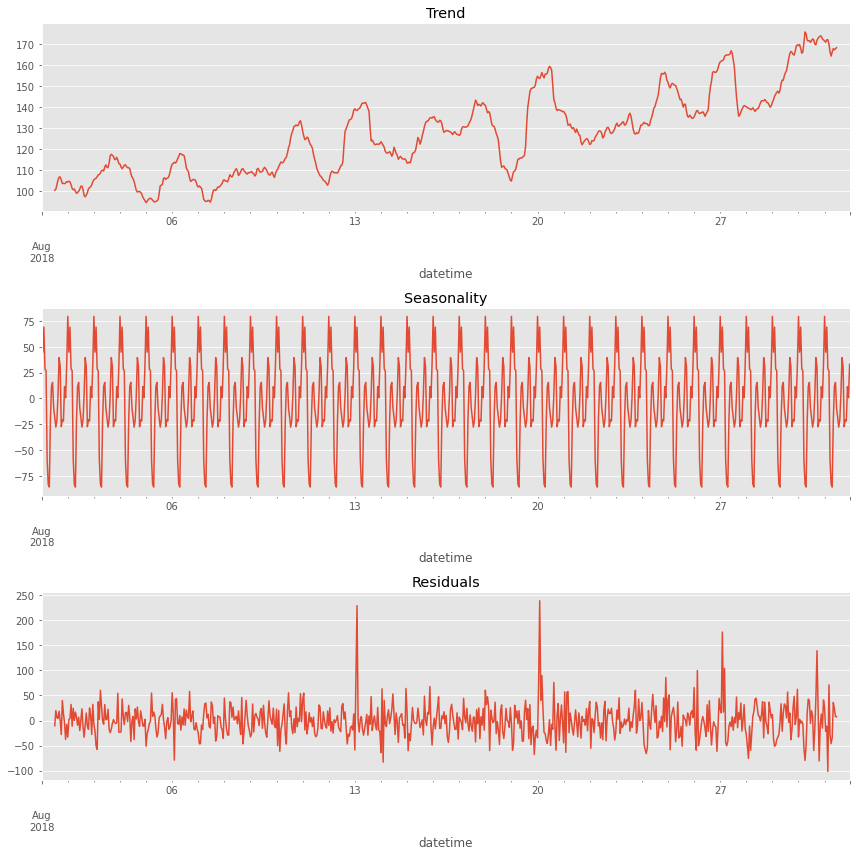

In [7]:
plt.style.use('ggplot')
decomposed = seasonal_decompose(taxi['2018-08':'2018-08'])
plt.figure(figsize=(12, 12))
plt.subplot(311)

decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')
plt.subplot(312)
decomposed.seasonal.plot(ax=plt.gca())

plt.title('Seasonality')
plt.subplot(313)
decomposed.resid.plot(ax=plt.gca())

plt.title('Residuals')
plt.tight_layout()

- Распределение сезонной части выглядит статическим в интервале суток. Ночью такси почти не заказывают, пик ближе к вечеру.
- Случайная часть также имеет постоянной среднее значение, но периодически возникают большие всплески (объясняются повышенным спросом на такси по выходным и праздникам)
- Трэнд показывает линейный рост количества заказов со временем. Построим тренд для всего временного ряда, чтобы увидеть полную картину.

Text(0.5, 1.0, 'Trend')

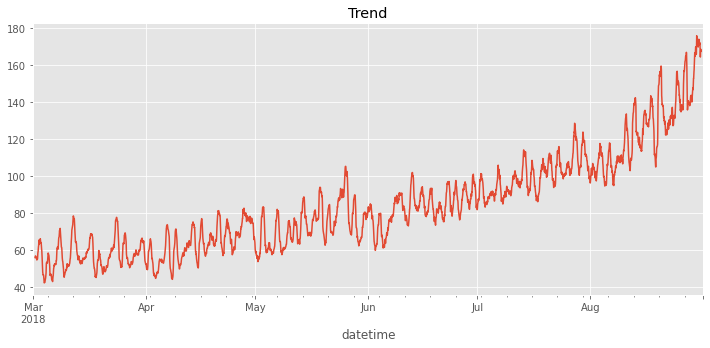

In [8]:
plt.style.use('ggplot')
decomposed = seasonal_decompose(taxi)
plt.figure(figsize=(12, 5))
decomposed.trend.plot(ax=plt.gca())
plt.title('Trend')

- Трэнд имеет более сложную зависимость от времени (квадраичная или экспоненциальная, сложно оценить по днной выборке). Для нашей задачи будем считать его линейным (предсказания нам нужны всего на час вперёд).
- Также заметим, что линия тренда имеет некоторый шум. Возможно, для предсказания будет необходимо применить скользящее среднее с окном в несколько десятков часов.

<a id='секция3'></a>
# 3. Обучение

В качестве baseline модели будем предсказывать новые значения предыдущими 

In [9]:
train, test = train_test_split(taxi, shuffle=False, test_size=0.2)
train = train.dropna()
pred_previous = test.shift()
pred_previous.iloc[0] = train.iloc[-1]
rmse_base =  mean_squared_error(test['num_orders'], pred_previous) ** 0.5
print("RMSE baseline модели:", round(rmse_base, 3))

RMSE baseline модели: 53.368


Проверим предсказания по среднему значению

In [10]:
pred_mean = np.ones(test.shape) * train['num_orders'].mean()
print("RMSE baseline модели:", mean_squared_error(test['num_orders'], pred_mean) ** 0.5)

RMSE baseline модели: 74.42015786913375


Предсказания по предыдущему значению показывают лучший результат. Возьмём их в качестве baseline.

Напишем функцию для создания обучающих признаков. Создадим признаки `day`, `dayofweek`. А также признаки для скользящего среднего `rolling_mean` (с размером окна `rolling_mean_size`), и `lag_i` для признаков отстающего значения.

In [11]:
def make_features(data, max_lag, rolling_mean_size):
    df = data.copy()
    df['dayofweek'] = df.index.dayofweek
    
    for lag in range(1, max_lag + 1):
        df['lag_{}'.format(lag)] = df['num_orders'].shift(lag)

    df['rolling_mean'] = df['num_orders'].shift().rolling(rolling_mean_size).mean()
    
    return df

In [12]:
df = make_features(taxi, 30, 50)

Для начала обучим линейную регрессию. Разделим данные в соотношении 9:1 (10% тестовой выборки).

In [13]:
train, test = train_test_split(df, shuffle=False, test_size=0.2)
train = train.dropna()

In [14]:
train.head(10)

,num_orders,dayofweek,lag_1,lag_2,lag_3,lag_4,lag_5,lag_6,lag_7,lag_8,...,lag_22,lag_23,lag_24,lag_25,lag_26,lag_27,lag_28,lag_29,lag_30,rolling_mean
datetime,,,,,,,,,,,,,,,,,,,,,
2018-03-03 02:00:00,25,5,108.0,163.0,72.0,119.0,101.0,93.0,49.0,89.0,...,20.0,64.0,75.0,120.0,90.0,58.0,113.0,66.0,61.0,62.82
2018-03-03 03:00:00,64,5,25.0,108.0,163.0,72.0,119.0,101.0,93.0,49.0,...,11.0,20.0,64.0,75.0,120.0,90.0,58.0,113.0,66.0,60.84
2018-03-03 04:00:00,44,5,64.0,25.0,108.0,163.0,72.0,119.0,101.0,93.0,...,11.0,11.0,20.0,64.0,75.0,120.0,90.0,58.0,113.0,60.42
2018-03-03 05:00:00,15,5,44.0,64.0,25.0,108.0,163.0,72.0,119.0,101.0,...,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,58.0,59.88
2018-03-03 06:00:00,9,5,15.0,44.0,64.0,25.0,108.0,163.0,72.0,119.0,...,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,90.0,58.86
2018-03-03 07:00:00,17,5,9.0,15.0,44.0,64.0,25.0,108.0,163.0,72.0,...,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,120.0,58.18
2018-03-03 08:00:00,56,5,17.0,9.0,15.0,44.0,64.0,25.0,108.0,163.0,...,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,75.0,58.40
2018-03-03 09:00:00,73,5,56.0,17.0,9.0,15.0,44.0,64.0,25.0,108.0,...,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,64.0,59.28
2018-03-03 10:00:00,52,5,73.0,56.0,17.0,9.0,15.0,44.0,64.0,25.0,...,36.0,91.0,54.0,45.0,46.0,7.0,11.0,11.0,20.0,60.44


In [15]:
X_train = train.drop('num_orders', axis = 1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis = 1)
y_test = test['num_orders']

lm = LinearRegression()
lm.fit(X_train, y_train)
preds_train = lm.predict(X_train)
print("RMSE на обучающей выборке:", mean_squared_error(y_train, preds_train) ** 0.5)

preds_test = lm.predict(X_test)
print("RMSE на тестовой выборке: ", mean_squared_error(y_test, preds_test) ** 0.5)

RMSE на обучающей выборке: 24.107441665527308
RMSE на тестовой выборке:  39.82156637969243


Подберём параметры для линейной регрессии более точно

In [16]:
%%time
best_lag_lm = 0
best_roll_size_lm = 0
best_rmse_lm = 48
for lag in range(1, 101, 5):
    for roll_size in range(1, 101, 5):

        df = make_features(taxi, lag, roll_size)
        train, test = train_test_split(df, shuffle=False, test_size=0.2)
        train = train.dropna()
        X_train = train.drop('num_orders', axis = 1)
        y_train = train['num_orders']
        X_test = test.drop('num_orders', axis = 1)
        y_test = test['num_orders']

        lm = LinearRegression()
        lm.fit(X_train, y_train)

        preds_test = lm.predict(X_test)
        rmse = mean_squared_error(y_test, preds_test) ** 0.5
        if rmse < best_rmse_lm :
            best_rmse_lm = rmse
            best_lag_lm = lag
            best_roll_size_lm = roll_size
            
print(f"RMSE на тестовой выборке: {best_rmse_lm}, максимальное смещение {best_lag_lm}, размер скользящего окна {best_roll_size_lm}")

RMSE на тестовой выборке: 35.67871438935064, максимальное смещение 96, размер скользящего окна 91
Wall time: 22.8 s


- Попробуем обучить модель с регуляризацией. Например, Lasso с L1 регуляризацией.

In [17]:
def model_build(model):
    best_lag = 0
    best_roll_size = 0
    best_alpha = 0
    best_rmse = 48
    for lag in range(1, 101, 5):
        for roll_size in range(1, 101, 5):
            for alpha in np.arange(0.1, 1, 0.2):

                df = make_features(taxi, lag, roll_size)
                train, test = train_test_split(df, shuffle=False, test_size=0.2)
                train = train.dropna()
                X_train = train.drop('num_orders', axis = 1)
                y_train = train['num_orders']
                X_test = test.drop('num_orders', axis = 1)
                y_test = test['num_orders']
                
                if model == 'Lasso' :
                    lm = Lasso(alpha=alpha)
                elif model == 'Ridge' :
                    lm = Ridge(alpha=alpha)
                lm.fit(X_train, y_train)

                preds_test = lm.predict(X_test)
                rmse = mean_squared_error(y_test, preds_test) ** 0.5
                if rmse < best_rmse :
                    best_rmse = rmse
                    best_lag = lag
                    best_roll_size = roll_size
                    best_alpha = alpha
    return best_rmse, best_lag, best_roll_size, best_alpha


In [18]:
%%time
best_rmse_ls, best_lag_ls, best_roll_size_ls, best_alpha_ls = model_build("Lasso")
print(f"===== Модель Lasso =====")
print(f"RMSE на тестовой выборке: {best_rmse_ls}, максимальное смещение {best_lag_ls}, размер скользящего окна {best_roll_size_ls}")
print(f"Коэффициент регуляризации: {best_alpha_ls}")

===== Модель Lasso =====
RMSE на тестовой выборке: 35.67281060216996, максимальное смещение 96, размер скользящего окна 41
Коэффициент регуляризации: 0.9000000000000001
Wall time: 2min 27s


In [19]:
%%time
best_rmse_rg, best_lag_rg, best_roll_size_rg, best_alpha_rg = model_build("Ridge")
print(f"===== Модель Ridge =====")
print(f"RMSE на тестовой выборке: {best_rmse_rg}, максимальное смещение {best_lag_rg}, размер скользящего окна {best_roll_size_rg}")
print(f"Коэффициент регуляризации: {best_alpha_rg}")

===== Модель Ridge =====
RMSE на тестовой выборке: 35.694169666362185, максимальное смещение 96, размер скользящего окна 1
Коэффициент регуляризации: 0.1
Wall time: 1min 33s


<a id='секция4'></a>
# 4. Тестирование

Проверка на тестовой выборке была проведена в предыдущем пункте. Сейчас соберём данные в таблицу и проанализируем результат.

In [20]:
stats = pd.DataFrame([['Baseline', round(rmse_base, 3), 1, 0, np.nan],
                      ['Linear Regression', round(best_rmse_lm, 3), best_lag_lm, best_roll_size_lm, np.nan],
                      ['Lasso', round(best_rmse_ls, 3), best_lag_ls, best_roll_size_ls, best_alpha_ls],
                      ['Ridge', round(best_rmse_rg, 3), best_lag_rg, best_roll_size_rg, best_alpha_rg]],
                    columns = ['model', 'rmse', 'max_lag', 'roll_size', 'alpha'])

In [21]:
stats

,model,rmse,max_lag,roll_size,alpha
0,Baseline,53.368,1,0,NaN
1,Linear Regression,35.679,96,91,NaN
2,Lasso,35.673,96,41,0.9
3,Ridge,35.694,96,1,0.1


Для предсказаний модели Lasso с параметром регуляризации alpha=0.9 построим графики зависимостей целевого признака и предсказаний от времени. Проверим, в какие моменты модель была более точной и менее точной. Для наглядности графика построим последние 10 дней

In [22]:
df = make_features(taxi, 96, 41)
train, test = train_test_split(df, shuffle=False, test_size=0.2)
train = train.dropna()
X_train = train.drop('num_orders', axis = 1)
y_train = train['num_orders']
X_test = test.drop('num_orders', axis = 1)
y_test = test['num_orders']

lasso = Lasso(alpha=0.9)
lasso.fit(X_train, y_train)
preds_test = pd.Series(lasso.predict(X_test), index = y_test.index, name='preds')

In [23]:
df_preds = pd.concat([y_test, preds_test], axis=1)
df_preds.head(10)

,num_orders,preds
datetime,,
2018-07-26 04:00:00,131,127.387869
2018-07-26 05:00:00,83,75.378455
2018-07-26 06:00:00,21,48.722166
2018-07-26 07:00:00,39,65.843009
2018-07-26 08:00:00,80,61.754457
2018-07-26 09:00:00,138,109.017315
2018-07-26 10:00:00,142,92.892337
2018-07-26 11:00:00,86,107.615540
2018-07-26 12:00:00,102,114.649062


<AxesSubplot:xlabel='datetime', ylabel='num_orders'>

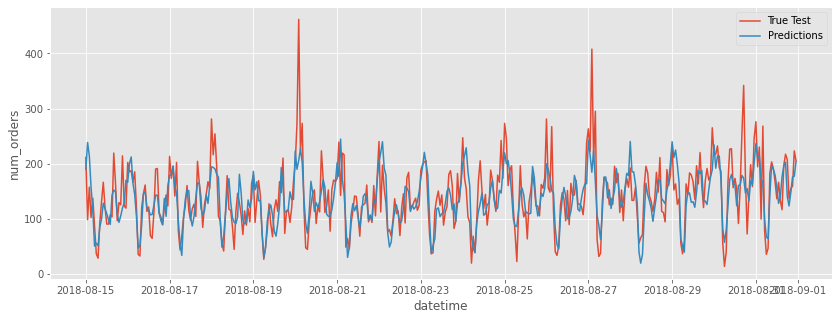

In [24]:
plt.figure(figsize=(14, 5))
plt.style.use('ggplot')
data = df_preds['2018-08-15':]
sns.lineplot(x=data.index, y=data['num_orders'], label='True Test')
sns.lineplot(x=data.index, y=data['preds'], label='Predictions')

- По графику видно, что модель достаточно точно определяет ежедневно повторяющиеся тестовые данные. Однако редки пики в данных (возможно, рост спроса на такси по выходным) предсказать не может. Возможно, для этого необходимо ввести признак 'выходной день'.

<a id='секция5'></a>
# Выводы

- Все линейные модели показали похожий результат по RMSE.
- Максимальное смещение ограничено значением 100 ввиду сложности модели. Дальше показатель RMSE не сильно растёт.
- Как и предполагалось, наилучшие результат даёт скользящее окно размером ~40-50 часов (около  двух дней, это значение хорошо сглаживает кривую тренда, судя по графику.)
- С помощью модели Lass eдалось уменьшить RMSE на 33% относительно baseline.
- По графику видно, что модель достаточно точно определяет ежедневно повторяющиеся тестовые данные. Однако редки пики в данных  предсказать не может.